# Chapter 6: Markov Chain Monte Carlo

In [3]:
import numpy as np
import matplotlib.pyplot as plt

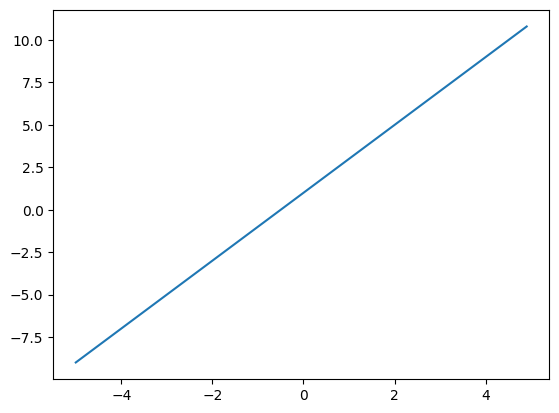

In [6]:
x = np.arange(-5, 5, 0.1)
y = 2 * x + 1
plt.plot(x, y)
# plt.show()
